# Implementation of a flow through a porous medium
modified by Javier E. Santos and Philipp Spelten


Description: This notebook calculates the steady-state single-phase laminar flow and the permeability of a domain with overlapping spheres

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import lettuce as lt

## Define Flow and Boundary Condition

In [2]:
class PeriodicPressureBC:
    """According to Ehsan Evati: 'High performance simulation of fluid flow in porous media...'
    """
    def __init__(self, lattice, delta_rho):
        self.lattice   = lattice
        self.delta_rho = delta_rho

    def __call__(self, f):
        f[[1,5,8], 0,:] = f[[1,5,8], 0,:] + self.lattice.w[[1,5,8],None] * self.delta_rho
        f[[3,6,7],-1,:] = f[[3,6,7],-1,:] - self.lattice.w[[3,6,7],None] * self.delta_rho
        return f


class PorousMedium2D(lt.Obstacle):
    def __init__(
            self,
            delta_rho_lu, 
            shape,
            reynolds_number,
            mach_number,
            lattice,
            char_length_lu
    ):
        super().__init__(
            shape,
            reynolds_number,
            mach_number,
            lattice,
            char_length_lu
        )
        self.delta_rho_lu = delta_rho_lu
    
    @property
    def boundaries(self):
        return [
            # left/right: push using PeriodicPressureBC
            PeriodicPressureBC(self.units.lattice, self.delta_rho_lu),
            # periodic in y direction
            lt.BounceBackBoundary(self.mask, self.units.lattice)
        ]

## Setting up domain and flow parameters

In [3]:
# user-defined parameters for
nx = 500 # domain length in x-dir
ny = 500 # domain length in y-dir

# MASK and ITERATION user-defined parameters for
n_buffer = 10   # number of buffer layers
it_check = 500  # check for convergence of floating avg every n-iterations of it_floating_avg
it_floating_avg = 10 # take avg velocity every n-iterations for the floating avg
avgs_per_check = int(it_check//it_floating_avg)
it_max   = 1e6  # break after max its is reached
epsilon  = 0.1  # break after the diff between its it's less than e %
                # lower epsilon makes no sense, as the avg velocity continues changing

delta_rho_lu = 0.005 # forced pressure differential left and right

In [4]:
# Set up LATTICE
device = torch.device('cuda') # gpu
dtype  = torch.float64 # torch types: torch.float64 is stable and accurate
lattice = lt.Lattice(lt.D2Q9, device, dtype, use_native=False)

# FLOW parameters
Ma    = 0.05 # I set this arbitrarily
u_lbm = lattice.cs*Ma

omega = 1.0
nu    = (1/omega - 0.5)/(1/lattice.cs)**2
Re    = u_lbm*nx/nu

# Set up FLOW
flow = PorousMedium2D(
    delta_rho_lu, (ny, nx), reynolds_number=Re, mach_number=Ma,
    lattice=lattice, char_length_lu=nx
)

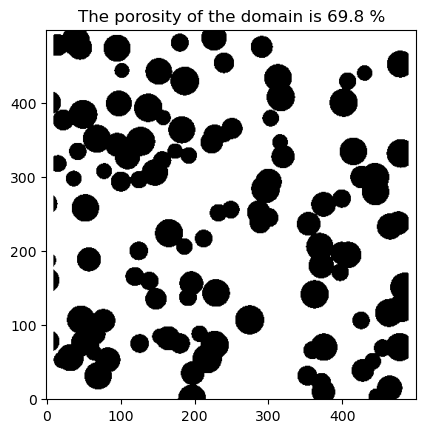

In [5]:
# make porous medium by inserting random CIRCLES
np.random.seed(234269)
n_circles = 125
x, y = flow.grid
for i in range(n_circles):
    x0 = np.random.rand()
    y0 = np.random.rand()
    r = 0.02 + 0.02 * np.random.rand() # radius between 0.02 and 0.04
    x0 = x0*nx
    y0 = y0*nx
    r = r*nx
    circle = ((x-x0)**2 + (y-y0)**2 < r**2)
    flow.mask[circle] = 1

# make a BUFFER region on left and right without obstacles
flow.mask[ :n_buffer, :] = 0
flow.mask[-n_buffer:, :] = 0

# calculate porosity
phi = 1-np.sum(flow.mask)/(nx*ny)

# Show MASK
plt.imshow(flow.mask.transpose(), origin="lower", cmap='gray_r')
plt.title(f'The porosity of the domain is {phi*100:2.1f} %');

# Set up SIMULATION
collision  = lt.KBCCollision2D(lattice, tau=flow.units.relaxation_parameter_lu)
streaming  = lt.StandardStreaming(lattice)
simulation = lt.Simulation(flow, lattice, collision, streaming)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=20, filename_base='./data/porous_example/out'))

## Run Simulation

In [6]:
# u_avg is the average velocity over the last couple of time steps
u_avg = [np.Inf]
for i in range(1,int(it_max//it_check)):
    u_avg_new = 0
    for j in range(it_floating_avg):
        simulation.step(avgs_per_check)
        u_avg_new += lattice.u(simulation.f).mean()
    u_avg_new = u_avg_new/it_floating_avg
    u_avg.append(u_avg_new)
    rel_change = ((u_avg[-1]-u_avg[-2])/u_avg[-1]*100).abs()
    print(f'it {i*it_check} u_avg[-1] = {u_avg[-1]} the relative change in mean vel is {rel_change} %')
    if rel_change < epsilon or not u_avg[-1] == u_avg[-1]:
        break

/home/philipp/lettuce/lettuce/simulation.py:122: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/TensorCompare.cpp:493.)
  self.f = torch.where(self.collision.no_collision_mask, self.f, self.collision(self.f))


it 500 u_avg[-1] = 0.0054741671178785214 the relative change in mean vel is inf %
it 1000 u_avg[-1] = 0.005503610678553043 the relative change in mean vel is 0.5349862552825457 %
it 1500 u_avg[-1] = 0.005222158321024156 the relative change in mean vel is 5.389579178321211 %
it 2000 u_avg[-1] = 0.005185957615364997 the relative change in mean vel is 0.6980524783292306 %
it 2500 u_avg[-1] = 0.004956002552603703 the relative change in mean vel is 4.6399302728462875 %
it 3000 u_avg[-1] = 0.0048701732160887305 the relative change in mean vel is 1.7623466909027738 %
it 3500 u_avg[-1] = 0.004863101108128699 the relative change in mean vel is 0.14542383147680815 %
it 4000 u_avg[-1] = 0.004754522131944467 the relative change in mean vel is 2.283699037905741 %
it 4500 u_avg[-1] = 0.004760336672434476 the relative change in mean vel is 0.12214557267931361 %
it 5000 u_avg[-1] = 0.004654535525756297 the relative change in mean vel is 2.2730763594502363 %
it 5500 u_avg[-1] = 0.004693044062040108 the

Text(0, 0.5, 'mean log10(|velocity|) [lus]')

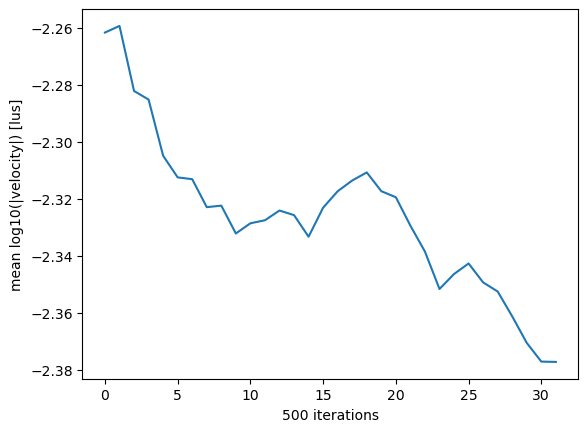

In [7]:
u_plot = [lattice.convert_to_numpy(x) for x in u_avg[1:]]
plt.plot(np.log10(np.abs(u_plot)))
plt.xlabel(f'{it_check} iterations')
plt.ylabel(f'mean log10(|velocity|) [lus]')

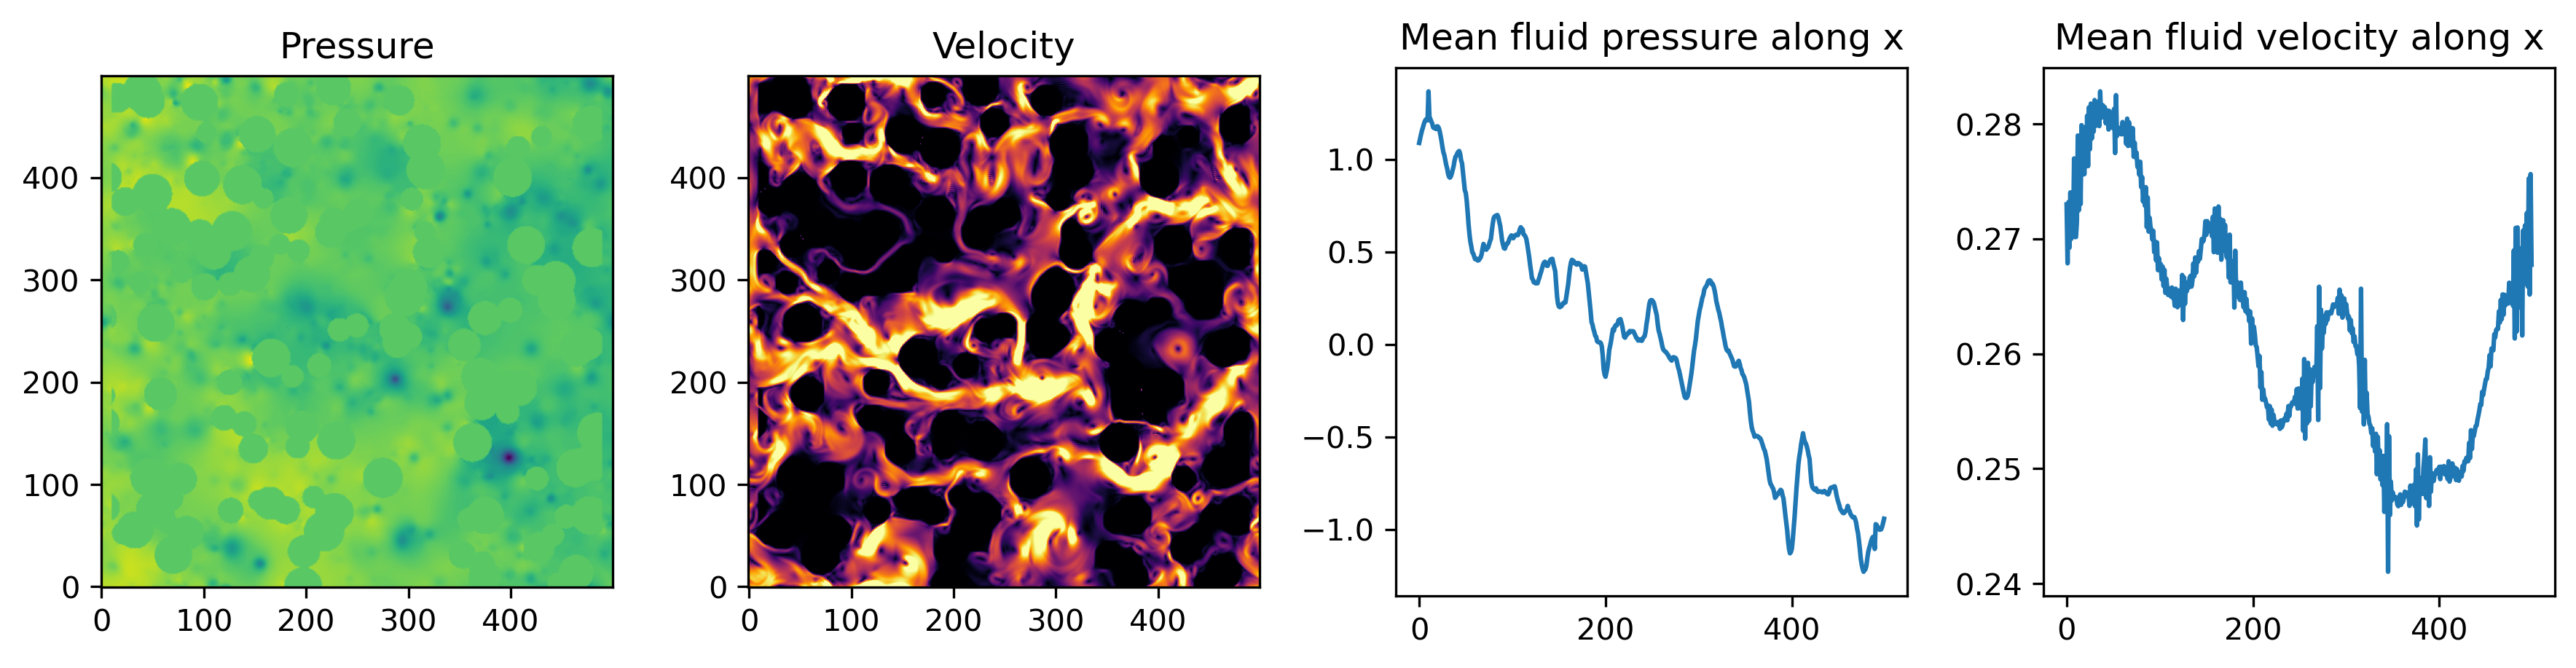

In [8]:
u = lattice.u(simulation.f)
k = nu*u.mean()/(delta_rho_lu/nx)**2
rho = lattice.rho(simulation.f)
u = lattice.convert_to_numpy(flow.units.convert_velocity_to_pu(u))
p = lattice.convert_to_numpy(flow.units.convert_density_lu_to_pressure_pu(rho))
unorm = np.linalg.norm(u, axis=0)

# Plot without outliers due to bounce-back contacts
fig, axes = plt.subplots(1,4, figsize=(12,3), dpi=300)
fig.tight_layout()
axes[0].set_title("Pressure")
axes[0].imshow(p[0].transpose(), origin="lower", )#vmin=p[0,ny-1,0], vmax=p[0].mean(axis=-1).max())
axes[1].set_title("Velocity")
axes[1].imshow(unorm.transpose(), origin="lower", cmap='inferno',
               vmin=np.percentile(unorm.flatten(),1),
               vmax=np.percentile(unorm.flatten(),95)
              )
axes[2].set_title("Mean fluid pressure along x")
axes[2].plot(p[0].sum(axis=-1)/(np.logical_not(flow.mask).sum(axis=-1)))
axes[3].set_title("Mean fluid velocity along x")
axes[3].plot(u[0].mean(axis=-1));


In [9]:
print(f'Porosity = {phi*100} % and Permeability = {k} [m^2]')

Porosity = 69.7768 % and Permeability = 7044775.455834101 [m^2]
